# **Genomic Data Clustering - Understanding the Genetic Code**


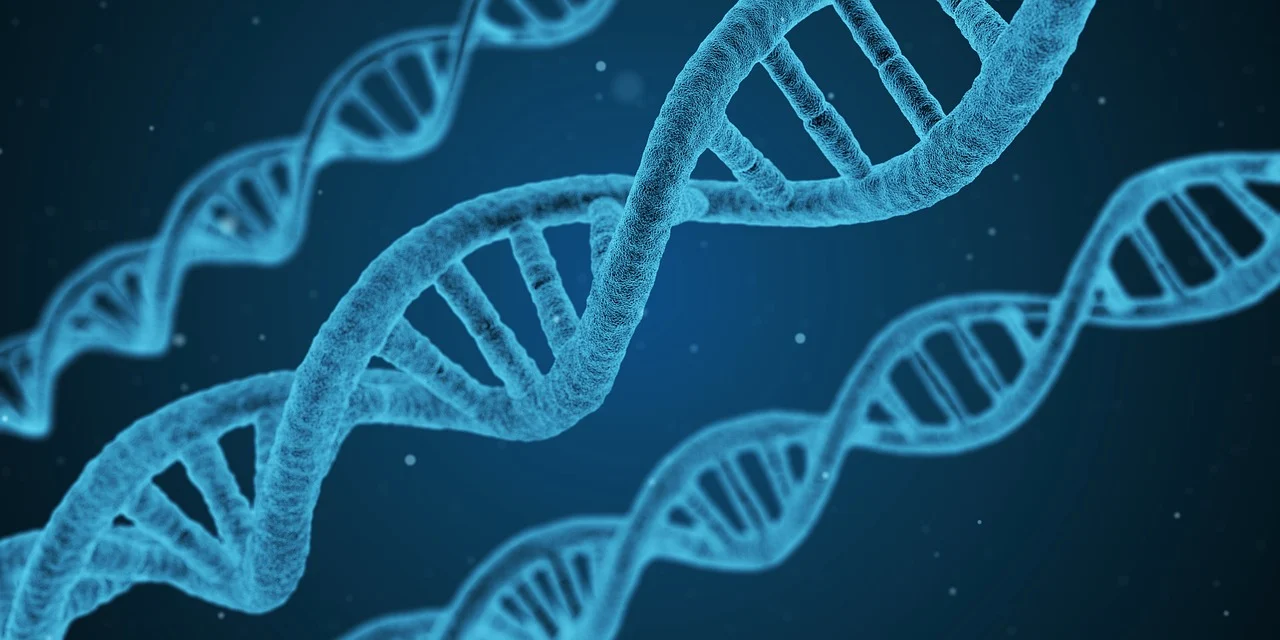

**Source:** [Pixabay](https://pixabay.com/illustrations/dna-helix-string-biology-3d-1811955/)


---------------------
## **Context**
---------------------

The discovery of DNA (Deoxyribonucleic Acid), and the critical role it plays in information storage for all biological beings, was a seminal moment for the biological sciences. All the information that is needed for the functioning of a living cell is encoded in and ultimately derived from the DNA of that cell, and this holds true for all biological organisms on the planet.

**DNA can be represented as a text sequence, with an alphabet that only has four letters** - A (Adenosine), C (Cytosine), G (Guanine), and T (Thymine). The diversity of living organisms and their complex properties is hidden in their genomic sequences. One of the most exciting problems in modern science is to understand the organization of living matter by reading genomic sequences. 

**One distinctive message in a genomic sequence is a piece of text, called a gene**. Genes can be oriented in the sequence in either the forward or backward directions. In the highest organisms (humans, for example), the notion of a gene is more complex. 

It was one of the many great discoveries of the twentieth century, that biological information is encoded in genes through **triplets of letters**, **called codons** in the biological literature. 


------------------------------------
## **About the data**
------------------------------------

The work starts with a fragment of the genomic sequence of the bacterium **Caulobacter crescentus**. This sequence is given as a long text file (300 kb), and the task is to look at the file and ensure that the text uses the alphabet of four letters (A, C, G, and T) and that these letters are used without spaces. It is noticeable that, although the text seems to be random, it is well organized, but we cannot understand it without special tools. Statistical methods may help us do so.

----------------------
## **Objective**
----------------------

In this exercise, we will see that it is possible to **verify the validity of the discovery of three-letter codons**, simply by performing unsupervised machine learning on the genetic sequence.

In this case study, we accept data from a genome and have the goal of identifying useful genes versus noise. Unfortunately, we don't know which sequences of genes are useful, so we have to use Unsupervised Learning to infer this. 

In this notebook, we walk through the following series of steps:

  1. First, the data is imported and prepared. Initially, the sequence, a single string, is split into non-overlapping substrings of length 300, and we may then count the combinations of the distinct 1, 2, 3, and 4-length sequences of base pairs that appear in each possible substring.
  2. PCA is performed to try to identify the internal structure of the data.
  3. Finally, if PCA reveals some internal structure then we'll apply Clustering techniques to the dataset.

# Step 1. Importing the data 

## **Importing the libraries**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

import itertools

## **Data Preparation**

The file format often used for bioinformatics and genomic data is called **FASTA**. It is a normally encoded file with headers separating genetic information. We read the file and strip it of unwanted characters and store it as a string.

In [2]:
# Open the file and get an array of its lines 
with open ("data/ccrescentus.fa", "r") as inputFile:
    data = inputFile.readlines()
print('Lines in the file:', len(data))
data[:3]

Lines in the file: 1527


['>fragment of c.crescentus genome\n',
 'gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaagg\n',
 'cgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgagggcgaagggttggacgagaacttgctgcggtagctgccgtcatagccgacatagaactcgcccgtcttgcccaggaagtcgcccggaacattggcctcggcc\n']

In [3]:
# Concatenate each line from the second (first line is a description), and
# stripped of empty characters (remove '\n' at the end of each line)
geneticCode = ''.join([l.strip() for l in data[1:]])
    
# Count the presence of each genome (a, g, t, c)
aCount = geneticCode.count('a')
gCount = geneticCode.count('g')
tCount = geneticCode.count('t')
cCount = geneticCode.count('c')

print(f"""
Total letters: {len(geneticCode):,.0f}\n
A: {aCount:,.0f}
G: {gCount:,.0f}
T: {tCount:,.0f}
C: {cCount:,.0f}
""")


Total letters: 305,100

A: 49,330
G: 103,441
T: 50,260
C: 102,069



In [4]:
# For testing, we print a sample of the string and check if there are no wanted characters
print(geneticCode[0:30])

gccgatagcctatgatccccggcaggcccg


In [5]:
print('Test: only a, g, t, c?')
print(aCount + gCount + tCount + cCount == len(geneticCode))

Test: only a, g, t, c?
True


### **Converting Text to a Numerical Table**

#### **Creating Frequency Tables**

Now, we've got a string element containing the sequence. A word is any continuous piece of text that contains several subsequent letters. As there are no spaces in the text, separation into words is not unique. The next step is to separate it into smaller sub-strings and create frequency tables for each x-sized word. We start by separating the string into several sub-strings, of reasonable sample size, to become rows in our table.

**What is a "reasonable size" for a data point?**

Knowing that our string has 305,100 characters and that we are checking words with a maximum of 4 letters, take the size of 300. It generates 1017 data points and allows for 75 4-letter words. It seems reasonable, but do feel free to change it and see the impact. 

We clip the whole text into fragments of 300 letters, and calculate the frequencies of short words (of length 1 - 4) inside every fragment. This will give us a description of the text in the form of a numerical table. There will be four such tables for every short word length choice from 1 to 4. 

As there are only four letters, there are four possible words of length 1 (singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words of length 3 (triplets), and 256 = 4^4 possible words of length 4 (quadruplets). The first table contains four columns (frequency of every singlet), and the number of rows equals the number of fragments. The second table has 16 columns and the same number of rows as the number of fragments, and so on.

In [6]:
# Size of the sub strings (data points)
size = 300

# Transforming the string in chunks of 300 characters length.
dataPoints = [geneticCode[i:i+300] for i in range(0, len(geneticCode), 300)]

print('Lines in geneticCode of 300 char size:', len(dataPoints))
dataPoints[0]

Lines in geneticCode of 300 char size: 1017


'gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg'

**Now let's create a list with the combinations of words possible**

In [7]:
# import itertools
# Getting all possible combinations
iterables = ['a', 'g', 't', 'c']
combinations = list(itertools.product(iterables, repeat=2))

print('Possible combinations for 2 char size:', combinations)
print('Possible words: ', [''.join(w) for w in combinations])

Possible combinations for 2 char size: [('a', 'a'), ('a', 'g'), ('a', 't'), ('a', 'c'), ('g', 'a'), ('g', 'g'), ('g', 't'), ('g', 'c'), ('t', 'a'), ('t', 'g'), ('t', 't'), ('t', 'c'), ('c', 'a'), ('c', 'g'), ('c', 't'), ('c', 'c')]
Possible words:  ['aa', 'ag', 'at', 'ac', 'ga', 'gg', 'gt', 'gc', 'ta', 'tg', 'tt', 'tc', 'ca', 'cg', 'ct', 'cc']


In [8]:
import itertools

iterables = ['a', 'g', 't', 'c']
wordsDict = {}

# For words of size 1 to 4, we calculate the cartesian product to get all the possibilities
wordsDict = {i: [''.join(w) for w in itertools.product(iterables, repeat=i)] for i in range(1, 5)}

print(f"""
Size 1: {wordsDict[1]}

Size 2:
{wordsDict[2]}

Size 3:
{wordsDict[3]}

Size 4:
{wordsDict[4]}
""")


Size 1: ['a', 'g', 't', 'c']

Size 2:
['aa', 'ag', 'at', 'ac', 'ga', 'gg', 'gt', 'gc', 'ta', 'tg', 'tt', 'tc', 'ca', 'cg', 'ct', 'cc']

Size 3:
['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att', 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg', 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa', 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc', 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt', 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc']

Size 4:
['aaaa', 'aaag', 'aaat', 'aaac', 'aaga', 'aagg', 'aagt', 'aagc', 'aata', 'aatg', 'aatt', 'aatc', 'aaca', 'aacg', 'aact', 'aacc', 'agaa', 'agag', 'agat', 'agac', 'agga', 'aggg', 'aggt', 'aggc', 'agta', 'agtg', 'agtt', 'agtc', 'agca', 'agcg', 'agct', 'agcc', 'ataa', 'atag', 'atat', 'atac', 'atga', 'atgg', 'atgt', 'atgc', 'atta', 'attg', 'attt', 'attc', 'atca', 'atcg', 'atct', 'atcc', 'acaa', 'aca

Now, we create a DataFrame to begin the frequency matrix construction. From there, all that we need to do is to apply the count function for each word and store it as a new column. We do this for all 4 sizes of words.

In [9]:
# Dictionary that will contain the frequency table for each word size
freqTables = {}

for i in range(1, 5):
    df = pd.DataFrame(columns = wordsDict[i])       # Create an empty DataFrame with columns being the words on the dict. 
    
    for index, dataP in enumerate(dataPoints):      # 1017 lines, one row per each line of 300 char length
        df.loc[index] = np.zeros(len(wordsDict[i])) # Create a row with zero values corresponding to a data point
        
        while len(dataP) > 0:
            left = dataP[0:i]                       # Get the left part of the data point (i characters)
            df.loc[index, left] += 1                # Find it in the respective column and count it there
            dataP = dataP[i:]
    freqTables[i] = df

In [10]:
freqTables[1].head()

,a,g,t,c
0,54.0,104.0,49.0,93.0
1,51.0,102.0,43.0,104.0
2,36.0,106.0,61.0,97.0
3,46.0,112.0,55.0,87.0
4,48.0,105.0,65.0,82.0


In [11]:
freqTables[2].head()

,aa,ag,at,ac,ga,gg,gt,gc,ta,tg,tt,tc,ca,cg,ct,cc
0,6.0,17.0,6.0,6.0,4.0,20.0,11.0,16.0,3.0,6.0,5.0,10.0,6.0,10.0,3.0,21.0
1,7.0,8.0,2.0,6.0,5.0,17.0,8.0,22.0,4.0,6.0,6.0,4.0,12.0,19.0,7.0,17.0
2,0.0,11.0,5.0,5.0,8.0,14.0,7.0,21.0,1.0,12.0,9.0,13.0,6.0,19.0,5.0,14.0
3,4.0,10.0,0.0,7.0,6.0,17.0,11.0,20.0,6.0,13.0,5.0,6.0,9.0,18.0,9.0,9.0
4,3.0,14.0,4.0,5.0,12.0,14.0,8.0,16.0,0.0,15.0,8.0,11.0,7.0,12.0,11.0,10.0


In [12]:
freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,...,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0
1,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.0,0.0,...,2.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,4.0,0.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,5.0,5.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,8.0,3.0,1.0,5.0,1.0,0.0,0.0


In [13]:
freqTables[4].head()

,aaaa,aaag,aaat,aaac,aaga,aagg,aagt,aagc,aata,aatg,...,ccgt,ccgc,ccta,cctg,cctt,cctc,ccca,cccg,ccct,cccc
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, **we have our data in the optimal format to run PCA.**

# Step 2. Apply PCA to Observe the data in 2 dimensions

## **Principal Component Analysis**

- One reason why we're trying multiple word lengths, is because without additional domain knowledge it is not clear if there are more meaningful units we could work with than individual letters.  
- **So we calculate frequency tables to see if certain combinations happen more frequently (and more frequently together), and thus might be more meaningful, than others.**
- PCA helps us by creating natural clusters where combinations frequently co-occur and reducing the number of dimensions also enables us to visualize our dataset in a way that's otherwise not possible.

- The first step to running PCA is to **normalize the data** across columns.
- We do this to have the **same averages and dispersions across the data**, which is an important concept of both PCA and K-means, as they are distance-based algorithms.
- The **StandardScaler** function is used to achieve this.

**----------------NORMALIZING THE DATA----------------**

In [14]:
normFreqTables = {}

for i in range(1, 5):
    # Eliminate the string column from the data, leaving only the actual frequencies
    data = freqTables[i]
    data = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(data)
    
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])

**For testing, we check that the average of a column is close to zero and the stdev is close to 1**

In [15]:
normFreqTables[1].describe().T

,count,mean,std,min,25%,50%,75%,max
a,1017.0,2.532662e-17,1.000492,-3.271129,-0.590351,-0.054195,0.589191,3.162738
g,1017.0,9.082651e-17,1.000492,-3.433416,-0.726691,0.031193,0.680807,3.820609
t,1017.0,3.528260e-16,1.000492,-3.046342,-0.602146,-0.046647,0.619952,6.952643
c,1017.0,3.213861e-16,1.000492,-4.858062,-0.629864,-0.042615,0.662085,3.833233


In [16]:
normFreqTables[2].describe().T

,count,mean,std,min,25%,50%,75%,max
aa,1017.0,2.445329e-17,1.000492,-1.668296,-0.886066,-0.103836,0.678394,4.198430
ag,1017.0,6.637322e-17,1.000492,-2.569878,-0.597871,0.059464,0.716799,3.346141
at,1017.0,7.335987e-17,1.000492,-2.248135,-0.940900,-0.069411,0.802079,3.852293
ac,1017.0,-1.187731e-16,1.000492,-2.358052,-0.696601,-0.032020,0.632560,3.955462
ga,1017.0,-2.061063e-16,1.000492,-2.577336,-0.664553,-0.026958,0.610636,3.479810
gg,1017.0,5.152657e-17,1.000492,-2.701012,-0.690267,-0.187581,0.566449,3.582567
gt,1017.0,-1.117865e-16,1.000492,-2.591503,-0.786078,-0.063909,0.658261,4.269109
gc,1017.0,3.143994e-16,1.000492,-3.235664,-0.624884,0.027811,0.680506,3.943980
ta,1017.0,5.414657e-17,1.000492,-1.130029,-0.454403,-0.454403,0.221223,6.301856
tg,1017.0,-2.253196e-16,1.000492,-2.478602,-0.830630,-0.171441,0.487748,3.783693


In [17]:
normFreqTables[3].describe().T

,count,mean,std,min,25%,50%,75%,max
aaa,1017.0,-7.335987e-17,1.000492,-0.532468,-0.532468,-0.532468,0.923232,8.201732
aag,1017.0,4.541325e-17,1.000492,-0.744941,-0.744941,-0.182502,0.379937,7.129204
aat,1017.0,4.366659e-18,1.000492,-0.489290,-0.489290,-0.489290,-0.489290,6.257935
aac,1017.0,2.969328e-17,1.000492,-0.695124,-0.695124,-0.695124,0.142484,5.168130
aga,1017.0,1.013065e-16,1.000492,-0.755354,-0.755354,-0.002222,0.750911,6.022839
...,...,...,...,...,...,...,...,...
ctc,1017.0,-2.095996e-17,1.000492,-0.864618,-0.864618,-0.254405,0.355808,5.847724
cca,1017.0,-8.383985e-17,1.000492,-0.969892,-0.969892,-0.040660,0.423956,5.070117
ccg,1017.0,-4.191993e-17,1.000492,-1.455948,-0.655137,-0.254732,0.546079,4.550132
cct,1017.0,2.794662e-17,1.000492,-0.918264,-0.918264,-0.463824,0.445056,4.989455


In [18]:
normFreqTables[4].describe().T

,count,mean,std,min,25%,50%,75%,max
aaaa,1017.0,-1.397331e-17,1.000492,-0.247080,-0.247080,-0.247080,-0.247080,7.605441
aaag,1017.0,2.619995e-17,1.000492,-0.324736,-0.324736,-0.324736,-0.324736,8.601125
aaat,1017.0,2.619995e-17,1.000492,-0.216569,-0.216569,-0.216569,-0.216569,12.019581
aaac,1017.0,3.493327e-17,1.000492,-0.260558,-0.260558,-0.260558,-0.260558,6.805777
aaga,1017.0,-1.746664e-18,1.000492,-0.445345,-0.445345,-0.445345,-0.445345,8.181628
...,...,...,...,...,...,...,...,...
cctc,1017.0,-1.397331e-17,1.000492,-0.588688,-0.588688,-0.588688,1.051575,4.332100
ccca,1017.0,-3.143994e-17,1.000492,-0.558801,-0.558801,-0.558801,1.055689,4.284667
cccg,1017.0,8.733318e-17,1.000492,-0.724082,-0.724082,-0.724082,0.629579,4.690560
ccct,1017.0,-1.746664e-17,1.000492,-0.562225,-0.562225,-0.562225,1.235835,4.831956


**----------------APPLYING PCA COMPONENTS----------------**

In [19]:
pca = PCA(n_components = 2)
pCompTables = {}

for i in range(1, 5):
    pca.fit(normFreqTables[i])
    pComponents = pca.transform(normFreqTables[i])
    
    # For each word size, we store the result of the PCA in a table containing only the first two princicipal components
    pCompTables[i] = pd.DataFrame(pComponents[:, [0, 1]], columns = ['pc1', 'pc2'])
    
    # Printing the percentage of variance explained by each of the selected components (n_components = 2).
    print(f'Explained variance for {i} letters: {pca.explained_variance_ratio_.sum()} {pca.explained_variance_ratio_}')

Explained variance for 1 letters: 0.748936349053428 [0.39925537 0.34968098]
Explained variance for 2 letters: 0.2277864890915617 [0.12115409 0.1066324 ]
Explained variance for 3 letters: 0.3167020193818015 [0.16500474 0.15169728]
Explained variance for 4 letters: 0.029344045720595475 [0.01689657 0.01244747]


In [20]:
# Reviewing the PCA generated tables (pCompTables)
for i in range(len(pCompTables)):
    print(f"""
    PCA applied to {i+1} letters dataset:
    {pCompTables[i+1].head(3)}
    """)


    PCA applied to 1 letters dataset:
            pc1       pc2
0  0.525495  0.259081
1 -0.355099 -0.762742
2 -0.292828  1.772081
    

    PCA applied to 2 letters dataset:
            pc1       pc2
0 -0.986146 -0.417895
1 -0.078336 -0.806661
2  1.167740  0.306913
    

    PCA applied to 3 letters dataset:
            pc1       pc2
0  1.329920  3.614123
1  1.855738  4.043604
2  2.350384  5.517204
    

    PCA applied to 4 letters dataset:
            pc1       pc2
0 -3.491814  1.378588
1 -2.369479  0.483567
2 -3.605163 -2.382630
    


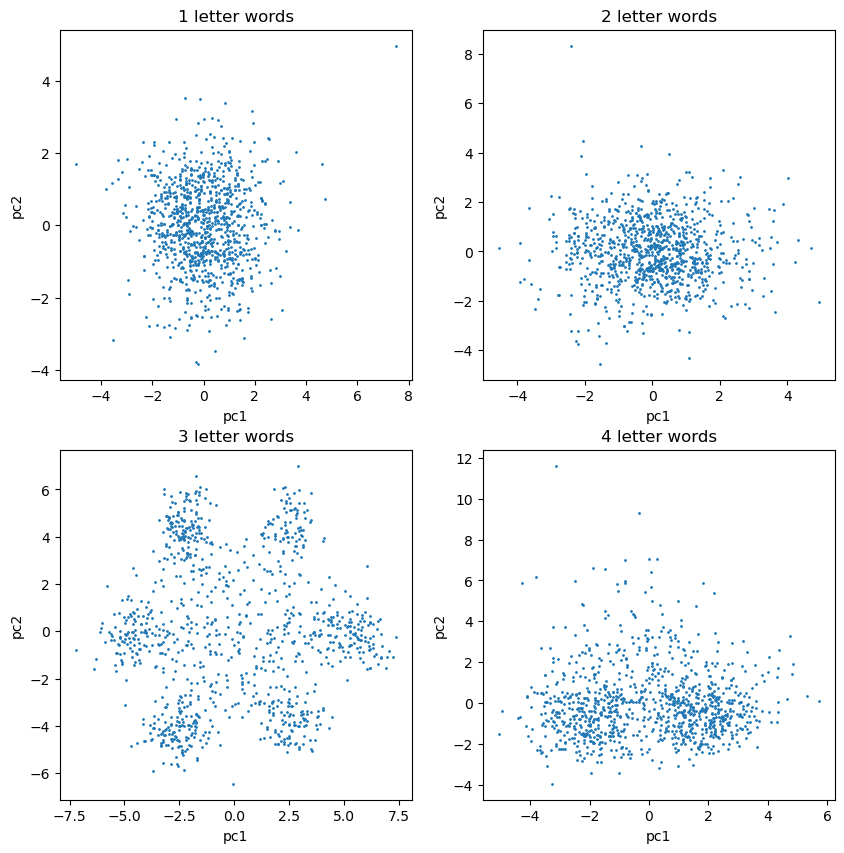

In [21]:
# Now, we finally need to plot these tables to try to find correlations visually
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(1, 5):
    plt.subplot(2, 2, i)    

    plt.scatter(pCompTables[i].pc1, pCompTables[i].pc2, s = 1)
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title(str(i) + ' letter words')

plt.show()

From the plots, we can clearly see that **3 letters** generates identifiable visual relations between data points in the first **two principal components**. **These 3 letter words are called codons in biology.**

**What do these point clouds (clusters) mean for the 3-letter words?** 

- We can identify 6 distinct poles, or centroids in the graph. If the genetic information is coded in 3-letter words, each of these clusters has similar distributions of frequencies of these words.

**Why 6 poles then?** 

- Well, since we don't know when a word starts, we can think that if we read the data point with the shift of 1 letter (i.e. not considering the first letter), it would still contain basically the same information. Therefore, in the 3 letter words hypothesis, we can find 3 distinct poles, each representing a shift in reading. The remaining 3 poles are explained since, we don't really know that all the genes read forward for the direction we chose for our strings, some might read backward, too. Hence, there are 6 poles for 3-letter words. 

- There are, however, 7 clusters, the last one being the points in the center of the figure, representing the bits of the code that do not carry information.

# Step 3. (Last) Apply clustering techniques to the dataset

## **Clustering**
We will now cluster the 3 letter word gene breakdown using the K-means Clustering unsupervised algorithm. From the previous section, we can detect 6 or 7 clusters. Knowing that some genes do not carry information, we are led to think that the center points, far from the 6 distinct centroids, could be a candidate for those. We, therefore, assume that there are 7 clusters (this could be checked by comparing the performance with 6 or 7 clusters).

In [22]:
normFreqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,-0.532468,-0.182502,-0.48929,1.817699,-0.755354,0.014249,-0.583623,0.079407,2.808515,-0.770880,...,0.061930,-0.907987,1.509856,-0.433313,-0.126264,1.576233,0.888572,0.145674,-0.463824,-0.621395
1,0.923232,-0.744941,-0.48929,1.817699,-0.755354,-0.438610,-0.583623,-1.042215,7.646901,-0.770880,...,0.061930,-0.164790,-0.448720,-0.080205,1.593524,0.355808,-0.505276,-1.055542,-0.918264,-0.621395
2,-0.532468,-0.182502,-0.48929,-0.695124,-0.755354,-0.891470,-0.583623,-1.042215,2.808515,-0.770880,...,0.061930,-0.164790,-0.448720,0.626012,2.166787,1.576233,-0.505276,-1.455948,-0.918264,-1.266252
3,0.923232,-0.744941,-0.48929,-0.695124,-0.755354,-0.891470,-0.583623,-1.042215,1.195720,-0.770880,...,-0.987779,-0.164790,-0.448720,0.979120,2.166787,0.355808,-0.040660,-1.455948,-0.918264,-1.266252
4,-0.532468,-0.744941,-0.48929,-0.695124,0.750911,-0.891470,0.625225,-1.042215,-0.417075,-0.108731,...,0.061930,-0.907987,-0.448720,2.038444,1.020261,-0.254405,1.353188,-1.055542,-0.918264,-1.266252


In [23]:
# To avoid the warning:
# UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available 
# threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
# import os
# os.environ["OMP_NUM_THREADS"] = '4'

# Code does not work, it is necessary to add to system environment and restart computer.
# Following the recommendation of: 
# https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am/

In [24]:
kmeans = KMeans(n_clusters = 7, n_init='auto')
kmeans.fit(normFreqTables[3])

KMeans(n_clusters=7, n_init='auto')

### **Results in a Graph**
Using our clustering results, we can visualize the different colors!

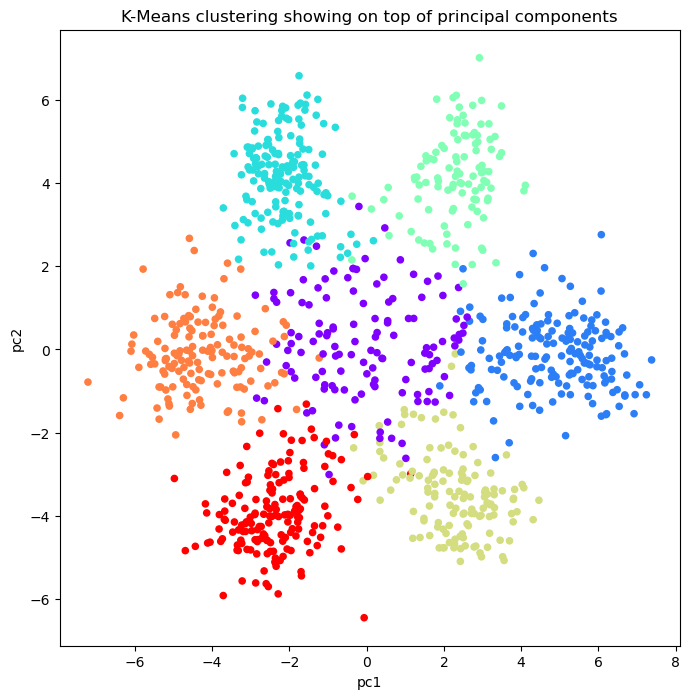

In [25]:
plt.figure(figsize = (8, 8))
plt.scatter(pCompTables[3].pc1, pCompTables[3].pc2, s=20, c=kmeans.labels_, cmap = 'rainbow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means clustering showing on top of principal components')
plt.show()

## **Conclusion**

Hence, Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed us to **visualize, validate, and provide supporting evidence for the biological discovery** that the DNA genetic sequence is organized into three-letter words called **codons**, which are responsible for the amino acids and proteins that are produced by living cells.